#Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
'''session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)'''
# for later versionsy
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [1]:
import glob  
import os  
import librosa 
import librosa.display
from PIL import Image
import numpy as np  
import random as python_random
from tensorflow.keras.models import Sequential,Model  
from tensorflow.keras.layers import Dense, Activation,Conv2D,MaxPooling2D,AveragePooling2D,GaussianNoise,TimeDistributed,LSTM,Attention
from tensorflow.keras.layers import Dropout,Flatten ,BatchNormalization,Bidirectional,Input,Concatenate,concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import ResNet50,DenseNet121,InceptionV3,EfficientNetB0,VGG16

import tensorflow as tf
import os
import tfdeterminism 
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from matplotlib import pyplot as plt
from matplotlib.image import imread

from sklearn.metrics import accuracy_score,auc,log_loss
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold  
from sklearn.metrics import confusion_matrix  ,accuracy_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,Normalizer
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt
os.environ['PYTHONHASHSEED']=str(101)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [2]:
 def custom_seeder(seed = 42):
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    tf.random.set_seed(seed)
    np.random.seed(seed)
    python_random.seed(seed)


In [3]:
data = pd.read_csv('Train_mel.csv')
test = pd.read_csv('test.csv')

swap_label = {x:y for x,y in zip(data.label.unique(),range(len(data.label.unique())))}

data.label.replace(swap_label,inplace=True)

In [4]:
data.head()

,fn,label,Sample_Length,Noise_fn,Noise_Amplitude,dB_Noise_SPL,Clip_Group,Prob_Accuracy,Audio_amplitude,dB_Audio_SPL,mel_path
0,PadSampleAudio/IV38R7F.wav,akawuka,60858,Noise_clip/IV38R7F.wav,0.008996,35,best,1.0,0.721681,73,mel/IV38R7F.png
1,PadSampleAudio/KM4SKWT.wav,banana,60858,Noise_clip/KM4SKWT.wav,0.356834,67,bad,0.2,0.966937,75,mel/KM4SKWT.png
2,PadSampleAudio/F5POSU9.wav,obulwadde,60858,Noise_clip/F5POSU9.wav,0.782890,74,bad,0.2,1.052848,76,mel/F5POSU9.png
3,PadSampleAudio/MMVDXG2.wav,nnyaanya,60858,Noise_clip/MMVDXG2.wav,0.015667,40,good,0.7,0.442655,69,mel/MMVDXG2.png
4,PadSampleAudio/9TVM96F.wav,pampu,60858,Noise_clip/9TVM96F.wav,0.743068,73,bad,0.2,0.765559,73,mel/9TVM96F.png


In [5]:
X = data[['mel_path','label']]
train_data , val_data = train_test_split(X,stratify = X.label,test_size = 0.25,random_state = 42)

In [6]:
data__data = X.copy().to_records(index = False)
test_test  = list(zip(test.copy().mel_path,range(len(test))))

In [7]:
train_tuple_data = train_data[['mel_path','label']].to_records(index =False)
val_tuple_data = val_data[['mel_path','label']].to_records(index =False)

In [8]:
train_tuple_data[0]

('mel/6E2BPU5.png', 'ensiringanyi')

In [9]:
 def load_images(tuple_data):
    mel_images = []
    labels = []
    for filename,label in tuple_data:
        photo = load_img(filename,target_size=(64,64))
        photo = img_to_array(photo)
        photo.astype('float32')
        photo /=255.0
        mel_images.append(photo)
        labels.append(label)
    mel_images  = np.asarray(mel_images)
    labels = np.asarray(labels)
    return mel_images,labels


In [10]:
def load_test_images(tuple_data):
    mel_images = []
    for filename,_ in tuple_data:
        photo = load_img(filename,target_size=(64,64))
        photo = img_to_array(photo)
        photo.astype('float32')
        photo /=255.0
        mel_images.append(photo)
    mel_images  = np.asarray(mel_images)
    return mel_images


In [10]:
X_mel_images,labels = load_images(data__data)

In [11]:
train_mel_images,train_labels = load_images(train_tuple_data)
val_mel_images,val_labels = load_images(val_tuple_data)

In [12]:
test_mel_images = load_test_images(test_test)

In [12]:
one_hot = OneHotEncoder(sparse=False).fit(train_labels.reshape(-1,1))
train_label_hot = one_hot.transform(train_labels.reshape(-1,1))
val_label_hot = one_hot.transform(val_labels.reshape(-1,1))

In [13]:
col_names = [x.split('_')[1] for x in one_hot.get_feature_names()]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_mel_images.reshape(-1, train_mel_images.shape[-1])).reshape(train_mel_images.shape)

X_val = scaler.transform(val_mel_images.reshape(-1, val_mel_images.shape[-1])).reshape(val_mel_images.shape)

In [51]:
python_random.shuffle([1,2,3,4])

In [266]:
np.random.seed(42)
max(abs(np.random.normal(0.55,0.09,4431)))

0.9033613935792695

In [170]:
def generate_rand(length,rand_state = 42):
    np.random.seed(rand_state)
    list_ = []
    for i in range(length+ 150):
        num = np.random.randint(0,length)
        list_.append(num)
    return list_

def mix_up(dataset,dataset_label,rand_state = 42):
    new_dataset = []
    new_dataset_label = []
    np.random.seed(rand_state)
    length = len(dataset)
    rand_index = generate_rand(length)
    alpha_range = abs(np.random.normal(0.6,0.05,length))
    for index in range(length):
        image1 = dataset[index]
        label1 = dataset_label[index]
        image2 = dataset[rand_index[index]]
        label2 = dataset_label[rand_index[index]]
        print(index,'___ ',rand_index[index],'__:::::::::__',np.argmax(label1),'____',np.argmax(label2))
        if np.argmax(label1) == np.argmax(label2):
            image2 = dataset[rand_index[index+1]]
            label2 = dataset_label[rand_index[index+1]]
        
        alpha1 = round(alpha_range[index],2)
        alpha2 = 1 - alpha1
        alpha2 = round(alpha2,2)
        
        new_image = alpha1 * image1 + alpha2 * image2
        new_label = alpha1 * label1 + alpha2 * label2
        new_dataset.append(new_image)
        new_dataset_label.append(new_label)
    return np.array(new_dataset),np.array(new_dataset_label)

In [171]:
train_mel_images.shape

(831, 64, 64, 3)

In [172]:
train_label_hot.shape

(831, 193)

In [173]:
x_img = train_mel_images[:35]
x_lab = train_label_hot[:35]

In [304]:
b= x_img[1][:,:,0]
c = x_img[1][:,:,2]

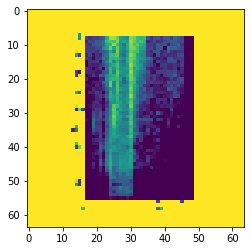

In [290]:
one_ch_img = x_img[1][:,:,1]
plt.imshow(one_ch_img)

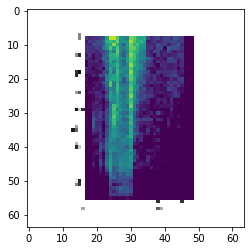

In [281]:
plt.imshow(x_img[1])

In [294]:
import random

In [295]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.15):
    random.seed(41)
    np.random.seed(43)
    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec
    

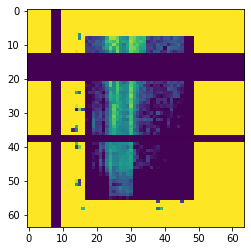

In [305]:
spec_a_img = spec_augment(one_ch_img)
plt.imshow(spec_a_img)

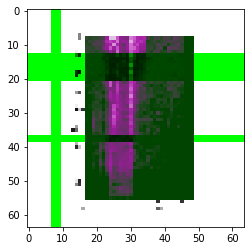

In [310]:
full_img = np.stack([spec_a_img,b,spec_a_img],axis = 2)
plt.imshow(full_img)

In [271]:
x_img[0].shape

(64, 64, 3)

In [174]:
a,b = mix_up(x_img,x_lab)

0 ___  28 __:::::::::__ 80 ____ 164
1 ___  14 __:::::::::__ 109 ____ 9
2 ___  7 __:::::::::__ 67 ____ 79
3 ___  20 __:::::::::__ 107 ____ 26
4 ___  18 __:::::::::__ 153 ____ 14
5 ___  22 __:::::::::__ 183 ____ 83
6 ___  10 __:::::::::__ 127 ____ 188
7 ___  10 __:::::::::__ 79 ____ 188
8 ___  23 __:::::::::__ 173 ____ 85
9 ___  23 __:::::::::__ 48 ____ 85
10 ___  2 __:::::::::__ 188 ____ 67
11 ___  21 __:::::::::__ 181 ____ 188
12 ___  1 __:::::::::__ 191 ____ 109
13 ___  23 __:::::::::__ 32 ____ 85
14 ___  29 __:::::::::__ 9 ____ 48
15 ___  1 __:::::::::__ 44 ____ 109
16 ___  20 __:::::::::__ 27 ____ 26
17 ___  32 __:::::::::__ 93 ____ 121
18 ___  11 __:::::::::__ 14 ____ 181
19 ___  21 __:::::::::__ 22 ____ 188
20 ___  24 __:::::::::__ 26 ____ 120
21 ___  26 __:::::::::__ 188 ____ 18
22 ___  27 __:::::::::__ 83 ____ 160
23 ___  15 __:::::::::__ 85 ____ 44
24 ___  14 __:::::::::__ 120 ____ 9
25 ___  2 __:::::::::__ 120 ____ 67
26 ___  6 __:::::::::__ 18 ____ 127
27 ___  20 __:::::::::_

In [132]:
a,b = mix_up(x_img,x_lab)

0 ___  1
1 ___  26
2 ___  10
3 ___  9
4 ___  22
5 ___  21
6 ___  4
7 ___  3
8 ___  5
9 ___  11
10 ___  10
11 ___  14
12 ___  29
13 ___  18
14 ___  29
15 ___  25
16 ___  24
17 ___  29
18 ___  6
19 ___  21
20 ___  22
21 ___  20
22 ___  5
23 ___  0
24 ___  5
25 ___  20
26 ___  19
27 ___  19
28 ___  21
29 ___  21


In [126]:
np.array(a).shape

(30, 64, 64, 3)

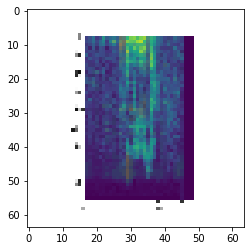

In [175]:
plt.imshow(a[0])

In [176]:
b[0][164]

0.62

In [178]:
b[4]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.71, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [80]:
6.16510052e-03

0.00616510052

In [110]:
np.random.seed(42)
abs(np.random.normal(0.33,0.01,length))

0.2907759974838166

In [111]:
round(0.2907759974838166,2)

0.29

In [24]:
def mix_up( X1, y1, X2, y2, ordered_outputs, target_lengths):
        assert X1.shape[0] == y1.shape[0] == X2.shape[0] == y2.shape[0]
        batch_size = X1.shape[0]
        l = np.random.beta(mix_up_alpha, mix_up_alpha, batch_size)
        X_l = l.reshape(batch_size, 1, 1, 1)
        y_l = l.reshape(batch_size, 1)
        X = X1 * X_l + X2 * (1-X_l)
        target_dict = {}
        i = 0
        for output in ordered_outputs:
            target_length = target_lengths[output]
            target_dict[output] = y1[:, i: i + target_length] * y_l + y2[:, i: i + target_length] * (1 - y_l)
            i += target_length
        y = None
        for output, target in target_dict.items():
            if y is None:
                y = target
            else:
                y = np.concatenate((y, target), axis=1)
        return X, y

In [27]:
a = train_mel_images[0]
b = train_mel_images[1]

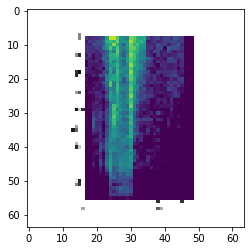

In [34]:
plt.imshow(b)

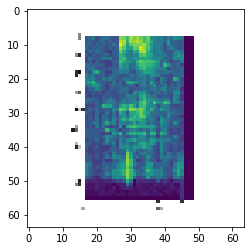

In [35]:
plt.imshow(a)

In [46]:
np.argmax(aa)

80

In [47]:
np.argmax(bb)

109

In [44]:
(aa *0.3 + bb * 0.7)[80:]

array([0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

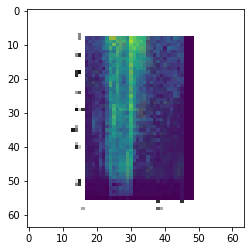

In [36]:
plt.imshow(a *0.3 + b * 0.7)

In [23]:
aa = train_label_hot[0]
bb = train_label_hot[1]

In [ ]:
mix_up()

In [19]:
import os
import tensorflow as tf
os.environ['PYTHONHASHSEED']=str(43)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 43
tf.random.set_seed(seed)
np.random.seed(seed)
python_random.seed(seed)
def conv_lstm_real():
   
    cnn = Sequential()
     
    # define CNN model
    cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((1, 3)))
    cnn.add(Conv2D(32, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())
    # define LSTM model
    model = cnn
   
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(193, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model
train_mel_images__ = train_mel_images.reshape((-1,64,64,3))
val_mel_images__ = val_mel_images.reshape((-1,64,64,3))
es = EarlyStopping(monitor='val_loss',mode = 'min',patience=5,restore_best_weights=True)


#model = conv_lstm()
#model.fit(train_mel_images__,train_label_hot,batch_size=64,validation_data=(val_mel_images__,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)
os.environ['PYTHONHASHSEED']=str(43)
os.environ['TF_DETERMINISTIC_OPS'] = 'True'

seed = 43
tf.random.set_seed(seed)
np.random.seed(seed)
python_random.seed(seed)
with tf.device("gpu:0"):
    print("tf.keras code in this scope will run on CPU")
    os.environ['PYTHONHASHSEED']=str(43)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    seed = 43
    tf.random.set_seed(seed)
    np.random.seed(seed)
    python_random.seed(seed)
    model = conv_lstm_real()
    # model.fit(train_mel_images__,train_label_hot,batch_size=64,validation_data=(val_mel_images__,val_label_hot),epochs=100,callbacks=[es],shuffle=False)

tf.keras code in this scope will run on CPU


In [20]:
tf.version.VERSION

'2.3.1'

In [22]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 4ms/step - loss: 5.2738


5.273844242095947

def conv_lstm_real():
   
    cnn = Sequential()
     
    # define CNN model
    cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    
    cnn.add(Conv2D(16, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((1, 3)))
    cnn.add(Conv2D(32, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())
    # define LSTM model
    model = cnn
   
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(193, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model
with tf.device("cpu:0"):
    
    model = conv_lstm_real()
    custom_seeder(101)
    model.fit(train_mel_images__,train_label_hot,batch_size=64,validation_data=(val_mel_images__,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)

In [127]:
def conv_lstm_real():
   
    cnn = Sequential()
     
    # define CNN model
    cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    
    cnn.add(Conv2D(16, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((1, 3)))
    cnn.add(Conv2D(32, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((2,2)))
  

    cnn.add(Flatten())
    # define LSTM model
    model = cnn
   
    model.add(Dense(512, activation='linear'))
    #model.add(Dropout(0.1))

    model.add(Dense(256, activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='linear'))
    model.add(Dropout(0.5))

    model.add(Dense(193, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model
with tf.device("cpu:0"):
    
    model = conv_lstm_real()
    custom_seeder(101)
    model.fit(train_mel_images,train_label_hot,batch_size=64,validation_data=(val_mel_images,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)

Epoch 1/100
13/13 [==============================] - 3s 198ms/step - loss: 5.5225 - val_loss: 5.2518
Epoch 2/100
13/13 [==============================] - 2s 153ms/step - loss: 5.3555 - val_loss: 5.2332
Epoch 3/100
13/13 [==============================] - 2s 155ms/step - loss: 5.3212 - val_loss: 5.2286
Epoch 4/100
13/13 [==============================] - 2s 160ms/step - loss: 5.2884 - val_loss: 5.2243
Epoch 5/100
13/13 [==============================] - 2s 159ms/step - loss: 5.2646 - val_loss: 5.1866
Epoch 6/100
13/13 [==============================] - 2s 155ms/step - loss: 5.2586 - val_loss: 5.1650
Epoch 7/100
13/13 [==============================] - 2s 156ms/step - loss: 5.2036 - val_loss: 5.1291
Epoch 8/100
13/13 [==============================] - 2s 158ms/step - loss: 5.1465 - val_loss: 5.0792
Epoch 9/100
13/13 [==============================] - 2s 148ms/step - loss: 5.1036 - val_loss: 5.0511
Epoch 10/100
13/13 [==============================] - 2s 148ms/step - loss: 5.0550 - val_lo

In [108]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.0608


4.060780048370361

In [128]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.1012


4.101215839385986

In [83]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.1554


4.155426502227783

In [90]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.1034


4.103447914123535

In [100]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.0963


4.09625768661499

In [102]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.0973


4.097270488739014

In [98]:
model.evaluate(val_mel_images,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.2183


4.218317985534668

In [54]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 5ms/step - loss: 4.2520


4.252000331878662

In [58]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 4ms/step - loss: 4.3121


4.3120903968811035

In [60]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 5ms/step - loss: 4.2107


4.21071720123291

In [62]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 4ms/step - loss: 4.3225


4.322463035583496

In [94]:
print("tf.keras code in this scope will run on CPU")
os.environ['PYTHONHASHSEED']=str(43)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
with tf.device('cpu:0'):
    os.environ['PYTHONHASHSEED']=str(43)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    seed = 43
    tf.random.set_seed(seed)
    np.random.seed(seed)
    python_random.seed(seed)
    model = conv_lstm_real()
    model.fit(train_mel_images__,train_label_hot,batch_size=64,validation_data=(val_mel_images__,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)

tf.keras code in this scope will run on CPU
Epoch 1/100
13/13 [==============================] - 2s 183ms/step - loss: 5.2930 - val_loss: 5.2554
Epoch 2/100
13/13 [==============================] - 2s 158ms/step - loss: 5.2572 - val_loss: 5.2427
Epoch 3/100
13/13 [==============================] - 2s 164ms/step - loss: 5.2437 - val_loss: 5.2322
Epoch 4/100
13/13 [==============================] - 2s 165ms/step - loss: 5.2405 - val_loss: 5.2297
Epoch 5/100
13/13 [==============================] - 2s 154ms/step - loss: 5.2281 - val_loss: 5.2311
Epoch 6/100
13/13 [==============================] - 2s 174ms/step - loss: 5.2278 - val_loss: 5.2267
Epoch 7/100
13/13 [==============================] - 2s 161ms/step - loss: 5.2240 - val_loss: 5.2159
Epoch 8/100
13/13 [==============================] - 2s 156ms/step - loss: 5.2199 - val_loss: 5.2161
Epoch 9/100
13/13 [==============================] - 2s 156ms/step - loss: 5.2212 - val_loss: 5.2194
Epoch 10/100
13/13 [===========================

In [89]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 5ms/step - loss: 4.3886


4.388638019561768

In [93]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 4ms/step - loss: 4.5390


4.538998126983643

In [51]:
def conv_lstm_real():
    os.environ['PYTHONHASHSEED']=str(43)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    seed = 43
    tf.random.set_seed(seed)
    np.random.seed(seed)
    python_random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    cnn = Sequential()
    # define CNN model
    cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((1, 3)))
    cnn.add(Conv2D(32, (3, 3), padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))


    model.add(Bidirectional(LSTM(1500,activation='relu',return_sequences=True)))
    #model.add(Dropout(0.5))
    model.add(LSTM(1500,activation='relu'))
    model.add(Dropout(0.3))

   
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(193, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model
train_mel_images__ = train_mel_images.reshape((-1,1,64,64,3))
val_mel_images__ = val_mel_images.reshape((-1,1,64,64,3))
es = EarlyStopping(monitor='val_loss',mode = 'min',patience=5,restore_best_weights=True)
'''tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
seed = 101
tf.random.set_seed(seed)
np.random.seed(seed)
python_random.seed(seed)'''
#model = conv_lstm()
#model.fit(train_mel_images__,train_label_hot,batch_size=64,validation_data=(val_mel_images__,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)

with tf.device("gpu:0"):
    print("tf.keras code in this scope will run on CPU")
    os.environ['PYTHONHASHSEED']=str(43)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    seed = 43
    tf.random.set_seed(seed)
    np.random.seed(seed)
    python_random.seed(seed)
    model = conv_lstm_real()
    model.fit(train_mel_images__,train_label_hot,batch_size=64,validation_data=(val_mel_images__,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)

tf.keras code in this scope will run on CPU
Epoch 1/100
13/13 [==============================] - 2s 123ms/step - loss: 5.2669 - val_loss: 5.2598
Epoch 2/100
13/13 [==============================] - 1s 83ms/step - loss: 5.2556 - val_loss: 5.2428
Epoch 3/100
13/13 [==============================] - 1s 81ms/step - loss: 5.2462 - val_loss: 5.2411
Epoch 4/100
13/13 [==============================] - 1s 79ms/step - loss: 5.2427 - val_loss: 5.2345
Epoch 5/100
13/13 [==============================] - 1s 56ms/step - loss: 5.2362 - val_loss: 5.2383
Epoch 6/100
13/13 [==============================] - 1s 77ms/step - loss: 5.2367 - val_loss: 5.2278
Epoch 7/100
13/13 [==============================] - 1s 75ms/step - loss: 5.2202 - val_loss: 5.2126
Epoch 8/100
13/13 [==============================] - 1s 54ms/step - loss: 5.2109 - val_loss: 5.2150
Epoch 9/100
13/13 [==============================] - 1s 60ms/step - loss: 5.2064 - val_loss: 5.2189
Epoch 10/100
13/13 [==============================] - 1

In [54]:
!pip install tensorflow-determinism

  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9161 sha256=7625fefd25d8e2d4469fcd14038e5c05466e040199e00f937b60030fa6ab64d8
  Stored in directory: c:\users\hamhamm\appdata\local\pip\cache\wheels\d2\be\33\2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


In [53]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.6396


4.639597415924072

In [44]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.6837


4.68366003036499

In [42]:
model.evaluate(val_mel_images__,val_label_hot) # ResNet50_model

9/9 [==============================] - 0s 7ms/step - loss: 4.6567


4.6566972732543945

In [268]:
tf.version.VERSION

'2.3.1'

In [22]:
# example of creating a CNN with an efficient inception module

# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

# define model input
visible = Input(shape=(64, 64, 3))
# add inception block 1
layer = inception_module(visible, 16, 32, 32, 16, 32, 32)
# add inception block 1
#layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
layer = Flatten()(layer)
layer = Dense(193,activation = 'softmax')(layer)
# create model
model = Model(inputs=visible, outputs=layer)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize model
#model.summary()
# plot model architecture
#plot_model(model, show_shapes=True, to_file='inception_module.png')
with tf.device("gpu:0"):
    print("tf.keras code in this scope will run on CPU")
    #model = conv_lstm_real()
    es = EarlyStopping(monitor='val_loss',mode = 'min',patience=5,restore_best_weights=True)
    model.fit(train_mel_images,train_label_hot,batch_size=64,validation_data=(val_mel_images,val_label_hot),epochs=100,callbacks=[es],validation_batch_size=64)

tf.keras code in this scope will run on CPU
Epoch 1/100
13/13 [==============================] - 2s 158ms/step - loss: 87.2180 - val_loss: 59.1486
Epoch 2/100
13/13 [==============================] - 1s 90ms/step - loss: 61.1312 - val_loss: 60.0962
Epoch 3/100
13/13 [==============================] - 1s 91ms/step - loss: 62.6859 - val_loss: 61.9041
Epoch 4/100
13/13 [==============================] - 2s 120ms/step - loss: 58.5632 - val_loss: 47.4907
Epoch 5/100
13/13 [==============================] - 2s 119ms/step - loss: 40.1951 - val_loss: 28.9728
Epoch 6/100
13/13 [==============================] - 2s 120ms/step - loss: 22.6110 - val_loss: 17.4077
Epoch 7/100
13/13 [==============================] - 2s 121ms/step - loss: 13.3931 - val_loss: 10.7219
Epoch 8/100
13/13 [==============================] - 2s 119ms/step - loss: 8.0455 - val_loss: 8.2531
Epoch 9/100
13/13 [==============================] - 2s 120ms/step - loss: 5.8678 - val_loss: 6.8975
Epoch 10/100
13/13 [===============

In [267]:
plt.imshow(np.array(load_img(train_latest_tuple_data[0][0]))[58: 229,53:166+224])

NameError: name 'train_latest_tuple_data' is not defined